# 0.0 Overview plots

In [1]:
prefix = '/home/ines/repositories/'
# prefix = '/Users/ineslaranjeira/Documents/Repositories/'

In [2]:

""" 
IMPORTS
"""
import os
import numpy as np
import seaborn as sns
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from one.api import ONE
from sklearn.preprocessing import StandardScaler,  LabelBinarizer
from scipy.stats import zscore


# Get my functions
# functions_path = prefix + '/representation_learning_variability//Models/Sub-trial//2_fit_models/'
# os.chdir(functions_path)
# from preprocessing_functions import idxs_from_files
# functions_path =  prefix + '/representation_learning_variability/Models/Sub-trial//3_postprocess_results/'
# os.chdir(functions_path)
# from postprocessing_functions import remove_states_str, state_identifiability, align_bin_design_matrix, states_per_trial_phase, broader_label
# os.chdir(functions_path)
# from plotting_functions import plot_avg_state, wheel_over_wavelet_clusters, plot_states_aligned
# functions_path =  prefix + '/representation_learning_variability/Functions/'
# os.chdir(functions_path)
# from data_processing import save_and_log

# Get my functions
from functions import idxs_from_files, state_identifiability, align_bin_design_matrix, states_per_trial_phase, broader_label
from functions import define_trial_types, rescale_sequence, plot_binned_sequence
one = ONE(mode='remote')

# Parameters

In [3]:
# LOAD DATA
data_path = prefix + 'representation_learning_variability/paper-individuality/data/design_matrices/'
wavelet_path = prefix + 'representation_learning_variability/paper-individuality/data/paw_wavelets/'

all_files = os.listdir(data_path)
design_matrices = [item for item in all_files if 'design_matrix' in item and 'standardized' not in item]
idxs, mouse_names = idxs_from_files(design_matrices)

""" FITTING PARAMETERS """
num_iters = 100
num_states = 2
num_train_batches = 5
method='prior'
fit_method='em'
optimal_k = 8
threshold = 0

whisker_params = str(num_train_batches)+'_'+method+'_'+fit_method+'_zsc_'+'True/'
licking_params = str(num_train_batches)+'_'+method+'_'+fit_method+'_zsc_'+'False/'

states_path = prefix + 'representation_learning_variability/paper-individuality/data/hmm/most_likely_states/'
wavelet_states_path = prefix + 'representation_learning_variability/paper-individuality/data/paw_most_likely_states/'

var_interest_map = ['paw', 'whisker', 'lick']
path_sets = [wavelet_states_path, states_path + whisker_params, states_path+licking_params]

# Individual sessions

In [4]:
# Identify sessions available to process
sessions_to_process = []
for m, mat in enumerate(idxs):
    mouse_name = mat[37:]
    session = mat[:36]
    fit_id = str(mouse_name + session)
    whisker_filename = os.path.join(states_path + whisker_params, 'whisker_me' + '_' + fit_id)
    licks_filename = os.path.join(states_path + licking_params, 'Lick count' + '_' + fit_id)
    wavelet_filename = os.path.join(wavelet_states_path, "most_likely_states_" + str(optimal_k) + '_' + fit_id+'.npy')

    if os.path.exists(whisker_filename) and os.path.exists(licks_filename) and os.path.exists(wavelet_filename):
        sessions_to_process.append((mouse_name, session))

print(f"Found {len(sessions_to_process)} sessions to process.")

Found 218 sessions to process.


In [5]:
# Load preprocessed data
results_path =prefix + '/representation_learning_variability/paper-individuality/fig1_segmentation/'
filename_states = str(results_path + 'states_trial_type_09-29-2025')
states_file = pd.read_parquet(filename_states, engine='pyarrow')

In [7]:
if optimal_k == 8:
    identifiable_mapping = {'000': 0.0,
           '100': 1.0,
           '200': 2.0,
           '300': 3.0,
           '400': 4.0,
           '500': 5.0,
           '600': 6.0,
           '700': 7.0,
           
           '010': 8.0,
           '110': 9.0,
           '210': 10.0,
           '310': 11.0,
           '410': 12.0,
           '510': 13.0,
           '610': 14.0,
           '710': 15.0,

           '001': 16.0,
           '101': 17.0,
           '201': 18.0,
           '301': 19.0, 
           '401': 20.0, 
           '501': 21.0, 
           '601': 22.0, 
           '701': 23.0, 

           '011': 24.0,
           '111': 25.0,
           '211': 26.0,
           '311': 27.0,
           '411': 28.0,
           '511': 29.0,
           '611': 30.0,
           '711': 31.0,
           'nan': np.nan
           }
    # paw_mapping = {0:4, 1:1, 2:5, 3:7, 4:6, 5:2, 6:0, 7:3}
    paw_mapping = {0:1, 1:5, 2:3, 3:0, 4:6, 5:4, 6:7, 7:2}  # original

elif optimal_k == 5:
    identifiable_mapping = {'000': 0.0,
           '100': 1.0,
           '200': 2.0,
           '300': 3.0,
           '400': 4.0,
           
           '010': 5.0,
           '110': 6.0,
           '210': 7.0,
           '310': 8.0,
           '410': 9.0,

           '001': 10.0,
           '101': 11.0,
           '201': 12.0,
           '301': 13.0, 
           '401': 14.0, 

           '011': 15.0,
           '111': 16.0,
           '211': 17.0,
           '311': 18.0,
           '411': 19.0,
           'nan': np.nan
           }
    paw_mapping = {0:1, 1:2, 2:4, 3:0, 4:3} 
inverted_mapping = {v: k for k, v in identifiable_mapping.items()}
inverted_func = np.vectorize(inverted_mapping.get)
identifiable_func = np.vectorize(identifiable_mapping.get)


## Plot variables separately

In [14]:
whisker_mapping = {0.0:0.0,
           1.0:0.0,
           2.0:0.0,
           3.0:0.0,
           4.0:0.0,
           5.0:0.0,
           6.0:0.0,
           7.0:0.0,
           
           8.0:1.0,
           9.0:1.0,
           10.0:1.0,
           11.0:1.0,
           12.0:1.0,
           13.0:1.0,
           14.0:1.0,
           15.0:1.0,

           16.0:0.0,
           17.0:0.0,
           18.0:0.0,
           19.0:0.0, 
           20.0:0.0, 
           21.0:0.0, 
           22.0:0.0, 
           23.0:0.0, 

           24.0:1.0,
           25.0:1.0,
           26.0:1.0,
           27.0:1.0,
           28.0:1.0,
           29.0:1.0,
           30.0:1.0,
           31.0:1.0,
           }
licking_mapping = {0.0:0.0,
           1.0:0.0,
           2.0:0.0,
           3.0:0.0,
           4.0:0.0,
           5.0:0.0,
           6.0:0.0,
           7.0:0.0,
           
           8.0:0.0,
           9.0:0.0,
           10.0:0.0,
           11.0:0.0,
           12.0:0.0,
           13.0:0.0,
           14.0:0.0,
           15.0:0.0,

           16.0:1.0,
           17.0:1.0,
           18.0:1.0,
           19.0:1.0, 
           20.0:1.0, 
           21.0:1.0, 
           22.0:1.0, 
           23.0:0.0, 

           24.0:1.0,
           25.0:1.0,
           26.0:1.0,
           27.0:1.0,
           28.0:1.0,
           29.0:1.0,
           30.0:1.0,
           31.0:1.0,
           }

In [33]:
func = np.vectorize(whisker_mapping.get)

In [ ]:
identifiable_mapping = {'000': 0.0,
        '100': 4.0,
        '200': 8.0,
        '300': 12.0,
        '400': 16.0,
        '500': 20.0,
        '600': 24.0,
        '700': 28.0,
        
        '010': 1.0,
        '110': 5.0,
        '210': 9.0,
        '310': 13.0,
        '410': 17.0,
        '510': 21.0,
        '610': 25.0,
        '710': 29.0,

        '001': 2.0,
        '101': 6.0,
        '201': 10.0,
        '301': 14.0, 
        '401': 18.0, 
        '501': 22.0, 
        '601': 26.0, 
        '701': 30.0, 

        '011': 3.0,
        '111': 7.0,
        '211': 11.0,
        '311': 15.0,
        '411': 19.0,
        '511': 23.0,
        '611': 27.0,
        '711': 31.0,
        'nan': np.nan
        }

# inverted_mapping = {v: k for k, v in identifiable_mapping.items()}
# inverted_func = np.vectorize(inverted_mapping.get)
identifiable_func = np.vectorize(identifiable_mapping.get)

/tmp/ipykernel_3445/3801582492.py:64: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='upper left', bbox_to_anchor=(1, 1))


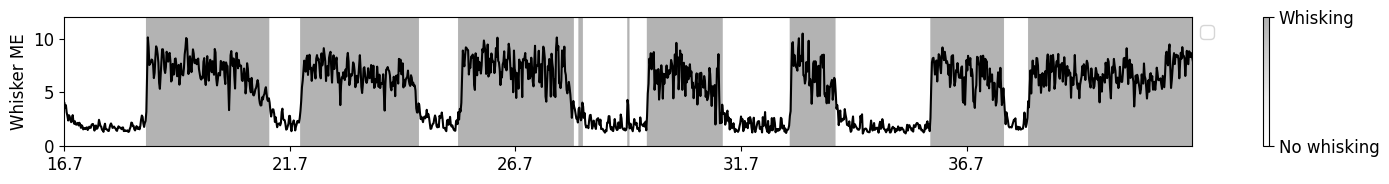

In [36]:
var_interest = 'Lick count'
var_interest = 'whisker_me'
# Plot raw trace over states       
init = 1000
inter = 1500
plot_var = 'avg_wheel_vel' if var_interest == 'wavelet' else var_interest
wheel_over_wavelet_clusters(init, inter, use_data, plot_var, session_trials, vlines=False)

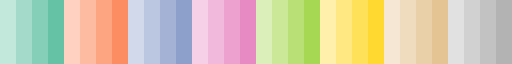

In [27]:
palette_16 = create_grouped_gradient_palette(n_groups=8, shades_per_group=4, base_palette='Set2')
palette_16

In [35]:
def wheel_over_wavelet_clusters(init, inter, empirical_data, var_to_plot, session_trials, vlines=False):
    # Plot raw trace over states
    # init should be in seconds; inter should be in frames
    frame_rate = 60

    fig, ax = plt.subplots(ncols=1 , nrows=1, sharex=False, sharey=False, figsize=[15, 2])
    plt.rc('font', size=12)
    
    if var_to_plot == 'avg_wheel_vel':
        ylabel = "Wheel velocity (rad/s)"
        state_ticks = [0., 1., 2., 3.]
        tick_labels = ['Wheel 0', 'Wheel 1', 'Wheel 2', 'Wheel 3']
        plot_min = -6
        plot_max = 6
        ax.set_xticks(np.arange(init, init+inter, inter/5), [])
        ax.set_xlabel('')
    elif var_to_plot == 'whisker_me':
        ylabel = "Whisker ME"
        state_ticks = [0., 1.]
        tick_labels = ['No whisking', 'Whisking']
        plot_min = 0
        plot_max = 12
        # ax.set_xticks(np.arange(init, init+inter, inter/5), [])
        ax.set_xticks(np.arange(init, init+inter, inter/5), np.round(np.arange(init/frame_rate, 
                        (init+inter)/frame_rate, (inter/frame_rate)/5), 1))
        ax.set_xlabel('')
    elif var_to_plot=='Lick count':
        ylabel = 'Lick count'
        state_ticks = [0., 1.]
        tick_labels = ['No licking', 'Licking']
        plot_min = 0
        plot_max = 3
        ax.set_yticks([0, 1, 2] ,[0, 1, 2])
        ax.set_xticks(np.arange(init, init+inter, inter/5), np.round(np.arange(init/frame_rate, 
                  (init+inter)/frame_rate, (inter/frame_rate)/5), 1))
        ax.set_xlabel("Time (s)")


    colormap = 'Greys'
    
    ax.plot(empirical_data.loc[empirical_data['Bin']>=init, var_to_plot].reset_index(), color='black')
    # plot_states = func(empirical_data.loc[empirical_data['Bin']>=init, 'most_likely_states'])
    sts = ax.imshow(np.concatenate([func(empirical_data.loc[empirical_data['Bin']>=init, 'most_likely_states'])])[None,:],
                extent=(0, len(np.concatenate([func(empirical_data.loc[empirical_data['Bin']>=init, 'most_likely_states'])])), plot_min, plot_max),
                aspect="auto",
                cmap=colormap,
                alpha=0.3)
    cbar = fig.colorbar(sts, ax=ax, ticks=state_ticks)
    cbar.ax.set_yticklabels(tick_labels)  # vertically oriented colorbar
    if vlines:
        ax.vlines(np.array(session_trials['goCueTrigger_times'] -init)*frame_rate, plot_min, plot_max, label='Stim On', 
                    color='Black', linewidth=2)
        ax.vlines(np.array(session_trials.loc[session_trials['feedbackType']==1, 'feedback_times'] * frame_rate)-init*frame_rate, 
                    plot_min, plot_max, label='Correct', color='Green', linewidth=2)
        ax.vlines(np.array(session_trials.loc[session_trials['feedbackType']==-1, 'feedback_times'] * frame_rate)-init*frame_rate, 
                    plot_min, plot_max, label='Incorrect', color='Red', linewidth=2)
        ax.vlines(np.array(session_trials['firstMovement_times'] * frame_rate)-init*frame_rate, plot_min, plot_max, label='First movement', color='Blue')
        ax.vlines(np.array(session_trials['intervals_0'] * frame_rate)-init*frame_rate, plot_min, plot_max, label='Trial end', color='Grey', linewidth=2)
        ax.vlines(np.array((session_trials['goCueTrigger_times'] - session_trials['quiescencePeriod']) * frame_rate)-init*frame_rate, 
                    plot_min, plot_max, label='Quiescence start', color='Pink', linewidth=2)

    ax.set_xlim([init, init+inter])
    ax.set_ylabel(ylabel)
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
    ax.set_ylim([plot_min, plot_max])

    plt.tight_layout()    
    # plt.savefig(save_path+'_'+var_to_plot+'over_states.svg', format="svg")
    plt.show()
    
    
from matplotlib.colors import ListedColormap, to_rgb, to_hex

def create_grouped_gradient_palette(n_groups=8, shades_per_group=4, base_palette='Set1'):
    # Pick n_groups distinct colors from base palette
    base_colors = sns.color_palette(base_palette, n_colors=n_groups)
    
    # Function to generate shades for a given color
    def generate_shades(color, n_shades):
        color_rgb = np.array(to_rgb(color))
        # Create shades by interpolating towards white (lighter) or black (darker)
        factors = np.linspace(0.4, 1.0, n_shades)  # You can adjust range for more/less contrast
        return [to_hex(color_rgb * factor + (1 - factor)) for factor in factors]
    
    # Build full palette
    full_palette = []
    for color in base_colors:
        shades = generate_shades(color, shades_per_group)
        full_palette.extend(shades)
    
    return ListedColormap(full_palette)


def plot_states_aligned_trial(trial_init, use_data, session_trials, trials_to_plot, inverted_mapping):
    
    fig, axs = plt.subplots(nrows=trials_to_plot, ncols=1, sharex=True, sharey=True, figsize=[8, 6])
    plt.rc('font', size=12)
    
    frame_rate = 60
    pre_stim = 1
    post_stim = 1
    average_window_size = (pre_stim + post_stim) * frame_rate
    palette_16 = create_grouped_gradient_palette(n_groups=8, shades_per_group=4, base_palette='Set2')
    stimOns = list(use_data['goCueTrigger_times'].drop_duplicates())

    for t in range(trials_to_plot):
        
        stimOn = stimOns[t]
        trial_init = stimOn - pre_stim
        bin_data = use_data.loc[(use_data['Bin']<(stimOn + post_stim)) & (use_data['Bin']> (stimOn - pre_stim))]
        trial_data = session_trials.loc[(session_trials['goCueTrigger_times']< (stimOn+2)) & 
                                        (session_trials['goCueTrigger_times']> (stimOn-2))]
        # Hacky solution to make sure color palette is used properly
        attach_array1 = np.arange(0, len(use_data['most_likely_states'].unique()), 1)
        attach_array = np.concatenate([np.arange(0, 10, 1)*np.nan, attach_array1])
        cax = axs[t].imshow(
            np.concatenate([bin_data['most_likely_states'], attach_array])[None,:], 
            extent=(0, len(np.concatenate([bin_data['most_likely_states'], attach_array])), -1, 1),
            aspect="auto",
            cmap=palette_16,
            alpha=1) 
        
        axs[t].vlines((stimOn-trial_init)* frame_rate,-1, 1, color='Black', linewidth=2)
        axs[t].vlines(np.array(trial_data.loc[trial_data['feedbackType']==1, 'feedback_times']-trial_init)* frame_rate,
                      -1, 1, label='Correct', color='Black', linewidth=2, linestyle=':')
        axs[t].vlines(np.array(trial_data.loc[trial_data['feedbackType']==-1, 'feedback_times']-trial_init)* frame_rate,
                      -1, 1, label='Incorrect', color='Black', linewidth=2, linestyle='--')
        # axs[t].vlines(np.array(trial_data['firstMovement_times']-trial_init)* frame_rate, -1, 1, 
        #               label='First movement', color='Blue')
        axs[t].vlines(np.array((trial_data['goCueTrigger_times'] - trial_data['quiescencePeriod'])-trial_init)* frame_rate,
                      -1, 1, label='Quiescence start', color='Black', linestyle='-.', linewidth=2)
    
    
    cbar = fig.colorbar(cax, ax=axs)
    cbar.set_label('Syllable')
    cbar.ax.invert_yaxis()
    if len(inverted_mapping) > 0:
        # Set the ticks and labels based on the dictionary
        cbar.set_ticks(list(inverted_mapping.keys()))
        cbar.set_ticklabels(list(inverted_mapping.values()))
        
    axs[t].set_yticks([] ,[])
    axs[t].set_xticks([0, (stimOn-trial_init)* frame_rate, (stimOn-trial_init+post_stim)* frame_rate] ,[-1, 0, 1.5])
    axs[t].set_xlabel(str('Time from stimulus onset (s)'))
    axs[t].set_xlim([0, average_window_size+1])

    axs[t].legend(loc='upper left', bbox_to_anchor=(1.4, 0))
    # plt.savefig(save_path+'trial_stack.svg', format="svg")
    plt.show()

""" State post-processing """
def prepro(trials):

    """ Performance """
    # Some preprocessing
    trials['contrastLeft'] = trials['contrastLeft'].fillna(0)
    trials['contrastRight'] = trials['contrastRight'].fillna(0)
    trials['signed_contrast'] = - trials['contrastLeft'] + trials['contrastRight']
    trials['contrast'] = trials['contrastLeft'] + trials['contrastRight']
    trials['correct_easy'] = trials['feedbackType']
    trials.loc[trials['correct_easy']==-1, 'correct_easy'] = 0
    trials['correct'] = trials['feedbackType']
    trials.loc[trials['contrast']<.5, 'correct_easy'] = np.nan
    trials.loc[trials['correct']==-1, 'correct'] = 0

    """ Response/ reaction times """
    trials['response'] = trials['response_times'] - trials['goCue_times']
    trials['reaction'] = trials['firstMovement_times'] - trials['goCue_times']
    """ Quiescence elongation """
    trials['elongation'] = trials['goCue_times'] - trials['quiescencePeriod'] - trials['intervals_0']
    """ Win stay lose shift """
    trials['prev_choice'] = trials['choice'] * np.nan
    trials['prev_choice'][1:] = trials['choice'][:-1]
    trials['prev_feedback'] = trials['feedbackType'] * np.nan
    trials['prev_feedback'][1:] = trials['feedbackType'][:-1]
    trials['wsls'] = trials['choice'] * np.nan
    trials.loc[(trials['prev_feedback']==1.) & (trials['choice']==trials['prev_choice']), 'wsls'] = 'wst'
    trials.loc[(trials['prev_feedback']==1.) & (trials['choice']!=trials['prev_choice']), 'wsls'] = 'wsh'
    trials.loc[(trials['prev_feedback']==-1.) & (trials['choice']!=trials['prev_choice']), 'wsls'] = 'lsh'
    trials.loc[(trials['prev_feedback']==-1.) & (trials['choice']==trials['prev_choice']), 'wsls'] = 'lst'
    #TODO : trials['days_to_trained'] = trials['training_time']

    return trials


def align_bin_design_matrix (init, end, event_type_list, session_trials, design_matrix, multiplier):
    
    for e, this_event in enumerate(event_type_list):
        
        # Initialize variables
        # Before there was a function for keeping validation set apart, now deprecated
        reduced_design_matrix = design_matrix.copy()
        # reduced_design_matrix['most_likely_states'] = most_likely_states
        reduced_design_matrix['new_bin'] = reduced_design_matrix['Bin'] * np.nan
        reduced_design_matrix['correct'] = reduced_design_matrix['Bin'] * np.nan
        reduced_design_matrix['choice'] = reduced_design_matrix['Bin'] * np.nan
        reduced_design_matrix['contrast'] = reduced_design_matrix['Bin'] * np.nan        
        reduced_design_matrix['block'] = reduced_design_matrix['Bin'] * np.nan        

        feedback = session_trials['feedbackType']
        choice = session_trials['choice']
        contrast = np.abs(prepro(session_trials)['signed_contrast'])
        block = session_trials['probabilityLeft']
        reaction = prepro(session_trials)['reaction']
        response = prepro(session_trials)['response']
        elongation = prepro(session_trials)['elongation']
        wsls = prepro(session_trials)['wsls']
        trial_id = session_trials['index'] 

        events = session_trials[this_event]
                
        for t, trial in enumerate(events[:-1]):
            event = events[t]
            trial_start = session_trials['intervals_0'][t]
            trial_end = session_trials['intervals_0'][t+1]
            
            # Check feedback
            if feedback[t] ==1:
                reduced_design_matrix.loc[(reduced_design_matrix['Bin']<= trial_end*multiplier) &
                                            (reduced_design_matrix['Bin']> trial_start*multiplier), 
                                            'correct'] = 1
            elif feedback[t] == -1:
                reduced_design_matrix.loc[(reduced_design_matrix['Bin']<= trial_end*multiplier) &
                                            (reduced_design_matrix['Bin']> trial_start*multiplier), 
                                            'correct'] = 0
            # Check choice
            if choice[t] ==1:
                reduced_design_matrix.loc[(reduced_design_matrix['Bin']<= trial_end*multiplier) &
                                            (reduced_design_matrix['Bin']> trial_start*multiplier), 
                                            'choice'] = 'right'
            elif choice[t] == -1:
                reduced_design_matrix.loc[(reduced_design_matrix['Bin']<= trial_end*multiplier) &
                                            (reduced_design_matrix['Bin']> trial_start*multiplier), 
                                            'choice'] = 'left'
            
            # Check reaction
            reduced_design_matrix.loc[(reduced_design_matrix['Bin']<= trial_end*multiplier) &
                                            (reduced_design_matrix['Bin']> trial_start*multiplier), 
                                            'reaction'] = reaction[t]
            # Check response
            reduced_design_matrix.loc[(reduced_design_matrix['Bin']<= trial_end*multiplier) &
                                            (reduced_design_matrix['Bin']> trial_start*multiplier), 
                                            'response'] = response[t]
            # Check elongation
            reduced_design_matrix.loc[(reduced_design_matrix['Bin']<= trial_end*multiplier) &
                                            (reduced_design_matrix['Bin']>trial_start*multiplier), 
                                            'elongation'] = elongation[t]

            # Check contrast
            reduced_design_matrix.loc[(reduced_design_matrix['Bin']<= trial_end*multiplier) &
                                            (reduced_design_matrix['Bin']> trial_start*multiplier), 
                                            'contrast'] = contrast[t]

            # Check block
            reduced_design_matrix.loc[(reduced_design_matrix['Bin']<= trial_end*multiplier) &
                                            (reduced_design_matrix['Bin']> trial_start*multiplier), 
                                            'block'] = block[t]
            
            # Check wsls
            reduced_design_matrix.loc[(reduced_design_matrix['Bin']<= trial_end*multiplier) &
                                            (reduced_design_matrix['Bin']> trial_start*multiplier), 
                                            'wsls'] = wsls[t]

            # Check trial id
            reduced_design_matrix.loc[(reduced_design_matrix['Bin']<= trial_end*multiplier) &
                                            (reduced_design_matrix['Bin']> trial_start*multiplier), 
                                            'trial_id'] = trial_id[t]
            
            # Add reliable timestamp to identify trial
            reduced_design_matrix.loc[(reduced_design_matrix['Bin']<= trial_end*multiplier) &
                                            (reduced_design_matrix['Bin']> trial_start*multiplier), 
                                            this_event] = event
            
            # Rename bins so that they are aligned on stimulus onset
            if event > 0:
                event_window = reduced_design_matrix.loc[(reduced_design_matrix['Bin']<= event*multiplier + end) &
                                                         (reduced_design_matrix['Bin']> event*multiplier + init)]
                onset_bin = reduced_design_matrix.loc[reduced_design_matrix['Bin']>= event*multiplier, 'Bin']
                if (len(event_window)>0) & len(onset_bin)>0:
                    bin = list(onset_bin)[0]
                    reduced_design_matrix.loc[(reduced_design_matrix['Bin']<= event*multiplier + end) &
                                            (reduced_design_matrix['Bin']> event*multiplier + init), 
                                            'new_bin'] = reduced_design_matrix.loc[(reduced_design_matrix['Bin']< event*multiplier + end) & 
                                            (reduced_design_matrix['Bin']>= event*multiplier + init), 'Bin'] - bin
                else:
                    reduced_design_matrix.loc[(reduced_design_matrix['Bin']<= event*multiplier + end) & 
                                              (reduced_design_matrix['Bin']> event*multiplier + init), 'new_bin'] = np.nan
            else:
                reduced_design_matrix.loc[(reduced_design_matrix['Bin']<= event*multiplier + end) & 
                                          (reduced_design_matrix['Bin']> event*multiplier + init), 'new_bin'] = np.nan
                
    return reduced_design_matrix

In [10]:
bin_size=.0167
palette_16 = create_grouped_gradient_palette(n_groups=8, shades_per_group=4, base_palette='Set2')
palette_16_list = [palette_16(i) for i in range(palette_16.N)]  # Extract colors properly
order = ['000', '100', '200', '300', '010', '110',
        '210', '310', '001', '101', '201', '301', '011',
        '111', '211', '311']
order = ['000', '010', '001', '011', '100', '110', '101', '111', '200', '210', '201', '211',
        '300', '310', '301', '311', '400', '410',  '401', '411',
        '500', '510', '501', '511', '600', '610', '601', '611',
        '700', '710', '701', '711']

labels = ['HR-00', 'HR-10', 'HR-01', 'HR-11', 'H-00', 'H-10', 'H-01', 'H-11', 'LL-00', 'LL-10', 'LL-01', 'LL-11',
         'Lowish00', 'Lowish10', 'Lowish01', 'Lowish11', 'Low00', 'Low10',  'Low01', 'Low11',
         'LR-00', 'LR-10', 'LR-01', 'LR-11', 'HL-00', 'HL-10', 'HL-01', 'HL-11',
         'VL00', 'VL10', 'VL01', 'VL11']
rename_labels = dict(zip(np.array(order), np.array(labels)))
rename_func = np.vectorize(rename_labels.get)

ordered_identifiable = ['700', '710', '701', '711',
                   '400', '410', '401', '411',
                   '300', '310', '301', '311', 
                   '200', '210', '201', '211',
                   '500', '510', '501', '511',
                   '100', '110', '101', '111', 
                   '600', '610', '601', '611',
                   '000', '010', '001', '011']

state_to_color = dict(zip(ordered_identifiable, palette_16_list))
state_to_color = dict(zip(order, palette_16_list))


/tmp/ipykernel_3445/3794799470.py:171: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  trials['prev_choice'][1:] = trials['choice'][:-1]
/tmp/ipykernel_3445/3794799470.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

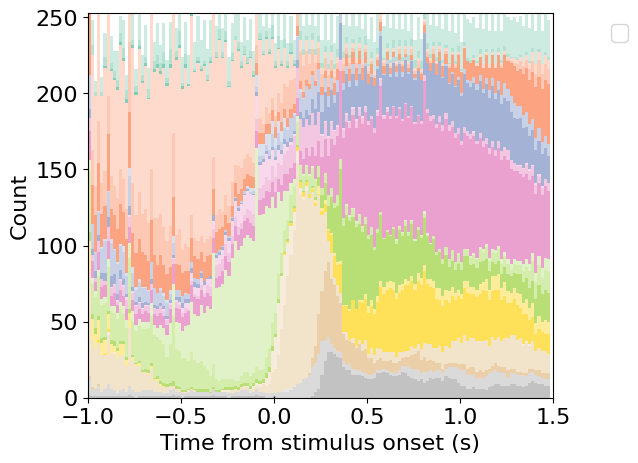

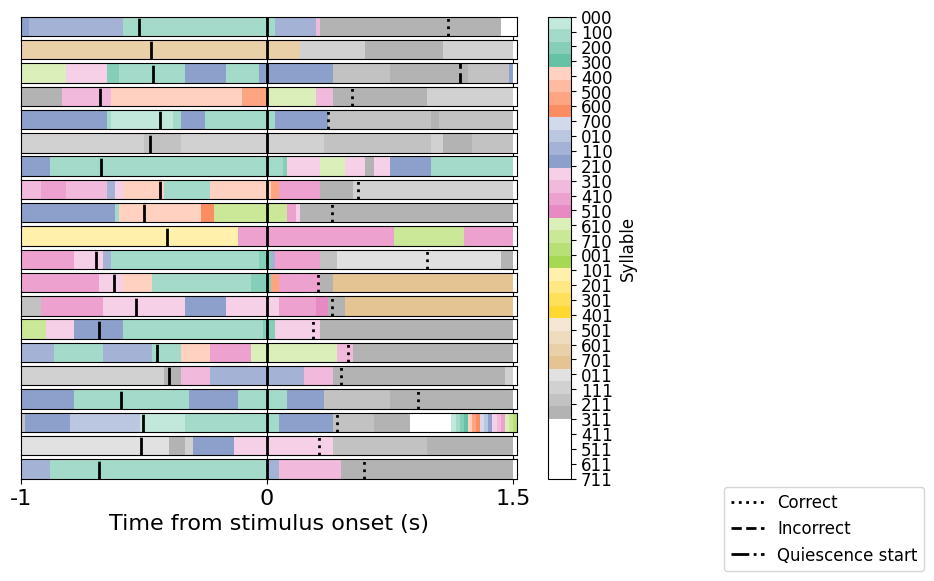

In [12]:
var_interest = ['paw', 'whisker_me', 'Lick count']
states_trial_type = pd.DataFrame(columns=['mouse_name', 'session', 'correct', 'choice', 'contrast', 
                                          'reaction', 'response', 'elongation', 'most_likely_states', 
                                          'identifiable_states', 'Bin', 'label'])
for m, mat in enumerate(sessions_to_process[95:96]):
    # 95:96
    mouse_name = mat[0]
    session = mat[1]
    fit_id = str(mouse_name+session)
    trials_file = data_path + "session_trials_" + str(session) + '_'  + mouse_name
    session_trials = pd.read_parquet(trials_file, engine='pyarrow').reset_index() 
    filename = data_path + "design_matrix_" + str(session) + '_'  + mouse_name
    design_matrix = pd.read_parquet(filename)
    
    mouse_df = states_file.loc[states_file['session']==session]

    # Align bins
    multiplier = 1
    event_type_list = ['goCueTrigger_times']  # , 'feedback_times', 'firstMovement_times'
    event_type_name = ['Go cue']  # , 'Feedback time', 'First movement onset'

    init = -1 * multiplier
    end = 1.5 * multiplier
    empirical_data = align_bin_design_matrix(init, end, event_type_list, session_trials, design_matrix, multiplier)
    
    use_data = mouse_df.merge(empirical_data[['trial_id', 'Bin', 'new_bin']], on=['Bin', 'trial_id'])

    plt.figure(figsize=[6, 5])
    plt.rc('font', size=16)
    # use_data['identifiable_states'] = rename_func(use_data['identifiable_states'])
    
    sns.histplot(x='new_bin', hue='identifiable_states', data=use_data, stat='count', alpha=.8, linewidth=0, 
                        multiple="stack", legend=True, palette=state_to_color, hue_order=order, binwidth=bin_size)
    plt.vlines(0, 0, 1, color='Black', linewidth=1)
    plt.legend(loc='upper left', bbox_to_anchor=(1.1, 1))
    plt.ylim(0, np.max(use_data.trial_id)/2)
    plt.xlim(-1, 1.5)
    plt.xlabel('Time from stimulus onset (s)')
    # plt.legend(labels)
    # plt.savefig(save_path+'trial_stack_histogram.svg', format="svg")
    plt.show()

    use_data['most_likely_states'] = identifiable_func(use_data['identifiable_states'])
    plot_states_aligned_trial(0, use_data, session_trials, 20, inverted_mapping)

# Normalized in time

In [63]:
## Get sequences per trial epoch
# results_path = prefix + 'representation_learning_variability/Models/Sub-trial/4_analyses/1_HMM_states/'
# filename = str(results_path + 'epoch_sequences_10_03-11-2025')
filename = str(data_path + 'all_sequences_5k_09-24-2025')
filename =  str(results_path + 'all_sequences_09-29-2025')
all_sequences = pd.read_parquet(filename)
# all_sequences = pickle.load(open(filename, 'rb'))

design_df = all_sequences.pivot(index=['sample', 'trial_type', 'mouse_name'], columns=['broader_label'], values='binned_sequence').reset_index().dropna()
var_names = design_df.keys()[-4:]
df = design_df.copy()
df['feedback'] = df['trial_type'].str.split().str[:1].str.join('')
df['choice'] = df['trial_type'].str.split().str[3:4].str.join('')
df['block'] = df['trial_type'].str.split().str[2:3].str.join('')
df['contrast'] = df['trial_type'].str.split().str[1:2].str.join('')
df['side'] = df['choice'].copy()
df.loc[(df['feedback']=='correct') & (df['choice']=='right'), 'side'] = 'left'
df.loc[(df['feedback']=='correct') & (df['choice']=='left'), 'side'] = 'right'

df['session'] = df['sample'].str.split().str[:1].str.join('')
df['trial_id'] = df['sample'].str.split().str[1:2].str.join('')
## Get timing data


# Get timing info
vars = ['trial_id', 'session', 'mouse_name']

elongation = pd.DataFrame(states_file.groupby(vars)['elongation'].mean()).reset_index()
elongation['trial_id'] = elongation['trial_id'].astype(str)
response = pd.DataFrame(states_file.groupby(vars)['response'].mean()).reset_index()
response['trial_id'] = response['trial_id'].astype(str)
reaction = pd.DataFrame(states_file.groupby(vars)['reaction'].mean()).reset_index()
reaction['trial_id'] = reaction['trial_id'].astype(str)

# Merge

merged_df = df.merge(elongation, on=['session', 'trial_id', 'mouse_name'])
merged_df = merged_df.merge(response, on=['session', 'trial_id', 'mouse_name'])
merged_df = merged_df.merge(reaction, on=['session', 'trial_id', 'mouse_name'])

merged_df['contrast'] = merged_df['contrast'].astype(float)
merged_df['block'] = merged_df['block'].astype(float)

# Timing quantiles and choice
merged_df['response_qt'] = pd.qcut(merged_df['response'], 4, labels=False)/4
merged_df['elongation_qt'] = pd.qcut(merged_df['elongation'], 4, labels=False)/4

merged_df['choice'] = merged_df['trial_type'].str.split().str[3:4].str.join('')
merged_df.loc[merged_df['choice']=='left', 'choice'] = 0
merged_df.loc[merged_df['choice']=='right', 'choice'] = 1

merged_df.loc[merged_df['feedback']=='correct', 'feedback'] = 1
merged_df.loc[merged_df['feedback']=='incorrect', 'feedback'] = 0
del states_file

## Get sequences per trial

In [64]:
all_sequences['session'] = all_sequences['sample'].str[:36]
design_df = all_sequences.pivot(index=['sample', 'trial_type', 'mouse_name', 'session'], columns=['broader_label'], values='binned_sequence').reset_index().dropna()
var_names = design_df.keys()[-4:]

In [65]:
ordered_numbers = np.arange(0, 32, 1)
rename_labels = dict(zip(np.array(ordered_identifiable), np.array(ordered_numbers)))
rename_labels = dict(zip(np.array(order), np.array(ordered_numbers)))
rename_func = np.vectorize(rename_labels.get)

In [ ]:
fix_mapping = {0: 4,
        1:1,
        2:5,
        3:7,
        4:6,
        5:2,
        6:0,
        7:3
        }

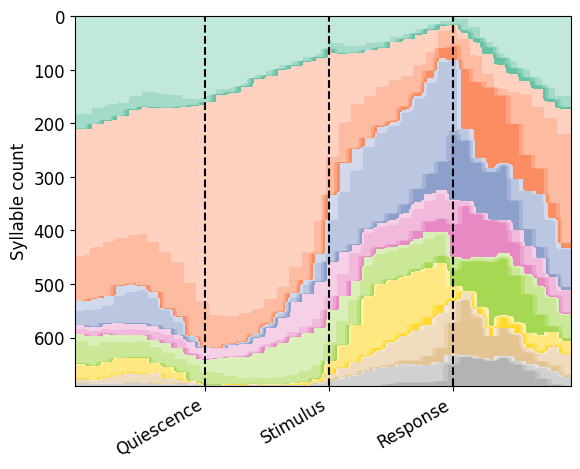

In [126]:
epoch_to_analyse = ['Pre-quiescence', 'Quiescence', 'Choice', 'ITI']
for m, mat in enumerate(sessions_to_process[105:106]):

    mouse_name = mat[0]
    session = mat[1]
    mouse_data = all_sequences.loc[all_sequences['session']==session]
    bound = int(np.shape(mouse_data)[0]/4)
    mouse_seq = np.ones((bound, 40)) * np.nan
    all_epochs = []
    for e, epoch in enumerate(epoch_to_analyse):
        epoch_data = np.vstack(mouse_data.loc[mouse_data['broader_label']==epoch, 'binned_sequence'].values)[:bound, :]
        epoch_data = inverted_func(epoch_data)
        # epoch_data = rename_func(epoch_data)
        epoch_data = identifiable_func(epoch_data)
        if e == 0:
            all_epochs = epoch_data[:bound-10, :]
        else:
            all_epochs = np.concatenate([all_epochs, epoch_data[:bound-10, :]], axis=1)
    # sorted = all_epochs[np.argsort([ordered_dict[row[0]] for row in all_epochs])]
    plt.imshow(np.sort(all_epochs, axis=0), aspect='auto', cmap=palette_16, interpolation=None, alpha=1)
    plt.axvline(x=10, color='k', linestyle='--')
    plt.axvline(x=20, color='k', linestyle='--')
    plt.axvline(x=30, color='k', linestyle='--')
    plt.ylabel('Syllable count')
    plt.xlabel('')
    plt.xticks(np.arange(10, 31, 10), ['Quiescence', 'Stimulus', 'Response'], rotation=30, ha='right')
    plt.show()

/tmp/ipykernel_16113/631908759.py:61: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='upper left', bbox_to_anchor=(1, 1))


NameError: name 'save_path' is not defined

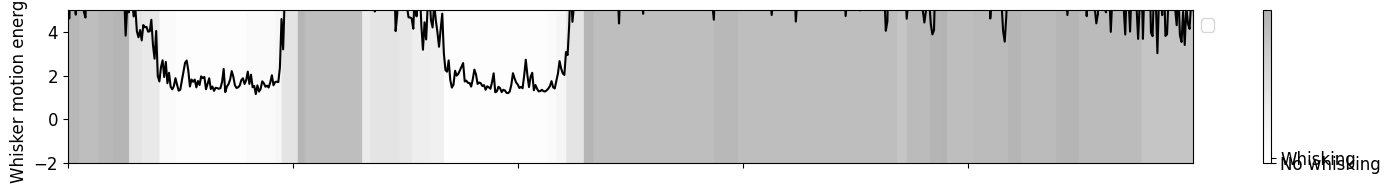

In [18]:
var_interest = 'whisker_me'
# Plot raw trace over states       
init = 500
inter = 700
plot_var = 'avg_wheel_vel' if var_interest == 'wavelet' else var_interest
wheel_over_wavelet_clusters(init, inter, use_data, plot_var, session_trials, vlines=False)

KeyError: "['paw'] not in index"

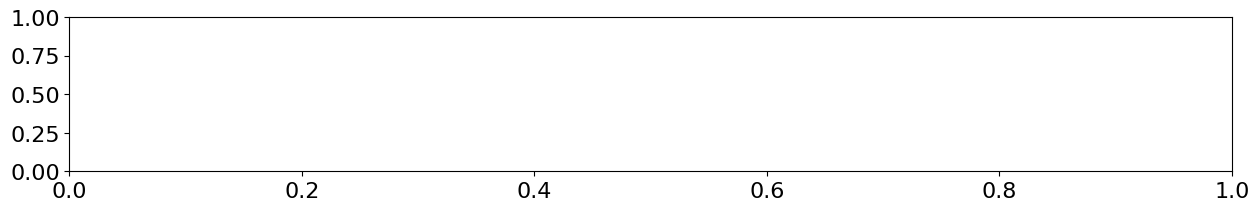

In [17]:

# # Plot raw trace over states       
init = 4000
inter = 500
plot_var = 'avg_wheel_vel' if var_interest == 'wavelet' else var_interest
wheel_over_wavelet_clusters(init, inter, empirical_data, plot_var, session_trials, vlines=False)


In [11]:
def wheel_over_wavelet_clusters(init, inter, empirical_data):
    # Plot raw trace over states
    # init should be in seconds; inter should be in frames
    frame_rate = 60
    plot_min = -5
    plot_max=5
    fig, ax = plt.subplots(ncols=1 , nrows=1, sharex=False, sharey=False, figsize=[12, 4])
    plt.rc('font', size=16)

    colormap = create_grouped_gradient_palette(n_groups=4, shades_per_group=4, base_palette='tab10')
    
    ax.plot(empirical_data.loc[empirical_data['Bin']>=init, 'avg_wheel_vel'].reset_index(), color='black', linestyle='--',linewidth=1)
    ax.plot(empirical_data.loc[empirical_data['Bin']>=init, 'whisker_me'].reset_index(), color='black',  linewidth=1)
    ax.plot(empirical_data.loc[empirical_data['Bin']>=init, 'Lick count'].reset_index(), color='black', linestyle='dashdot',linewidth=1)
    cax = ax.imshow(np.concatenate([empirical_data.loc[empirical_data['Bin']>=init, 'most_likely_states']])[None,:],
                extent=(0, len(np.concatenate([empirical_data.loc[empirical_data['Bin']>=init, 'most_likely_states']])), plot_min, plot_max),
                aspect="auto",
                cmap=colormap,
                alpha=0.5)
    cbar = fig.colorbar(cax, ax=ax)
    cbar.set_label('Syllable')
    cbar.ax.invert_yaxis()
    if len(inverted_mapping) > 0:
        # Set the ticks and labels based on the dictionary
        cbar.set_ticks(list(inverted_mapping.keys()))
        cbar.set_ticklabels(list(inverted_mapping.values()))

    ax.set_xlim([init, init+inter])
    ax.set_ylabel('')
    ax.set_xlabel("Time (s)")
    ax.set_xticks(np.arange(init, init+inter, inter/5), np.round(np.arange(init/frame_rate, 
                  (init+inter)/frame_rate, (inter/frame_rate)/5), 1))
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
    ax.set_ylim([plot_min, plot_max])

    plt.tight_layout()    
    plt.savefig(save_path+'conjunction_states_raw.svg', format="svg")

    plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


NameError: name 'save_path' is not defined

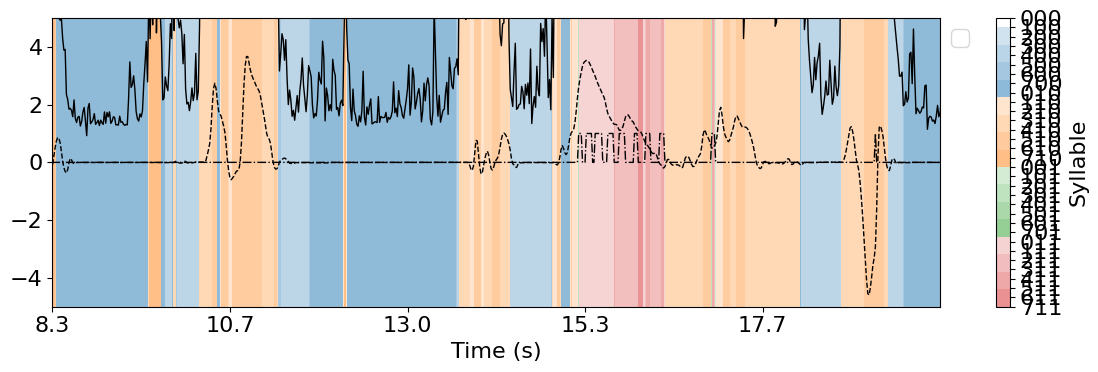

In [ ]:
init = 500
inter = 700
wheel_over_wavelet_clusters(init, inter, use_data)

In [32]:
zscore(empirical_data.loc[empirical_data['Bin']>=init, 'l_paw_x'], nan_policy='omit')

,index,l_paw_x
0,29456,0.848072
1,29457,0.848259
2,29458,0.847438
3,29459,0.843643
4,29460,0.842643
...,...,...
205707,235163,-0.015676
205708,235164,-0.015681
205709,235165,-0.015550
205710,235166,-0.015973


In [40]:
def plot_raw_trace(init, inter, empirical_data, var_to_plot):
    # Plot raw trace over states
    # init should be in seconds; inter should be in frames
    frame_rate = 60
    plot_min = -10
    plot_max=10
    fig, ax = plt.subplots(ncols=1 , nrows=3, sharex=True, sharey=False, figsize=[12, 8])
    plt.rc('font', size=16)

    
    ax[0].plot(np.array(zscore(empirical_data.loc[empirical_data['Bin']>=init, var_to_plot[0]], nan_policy='omit')), color='black', linewidth=2)
    ax[0].plot(np.array(zscore(empirical_data.loc[empirical_data['Bin']>=init, var_to_plot[1]], nan_policy='omit')), color='black', linewidth=2)
    ax[1].plot(np.array(empirical_data.loc[empirical_data['Bin']>=init, var_to_plot[2]]), color='black', linewidth=2)
    ax[2].plot(np.array(empirical_data.loc[empirical_data['Bin']>=init, var_to_plot[3]]), color='black', linewidth=2)

    ax[0].set_xlim([init, init+inter])
    ax[0].set_ylabel('')
    ax[0].set_xlabel("")
    ax[0].set_xticks([], [])
    ax[0].set_ylim([-4, 6])
    ax[1].set_ylim([0, 10])
    ax[2].set_ylim([-1, 2])
    plt.tight_layout()    
    # plt.savefig(save_path+'conjunction_states_raw.svg', format="svg")

    plt.show()

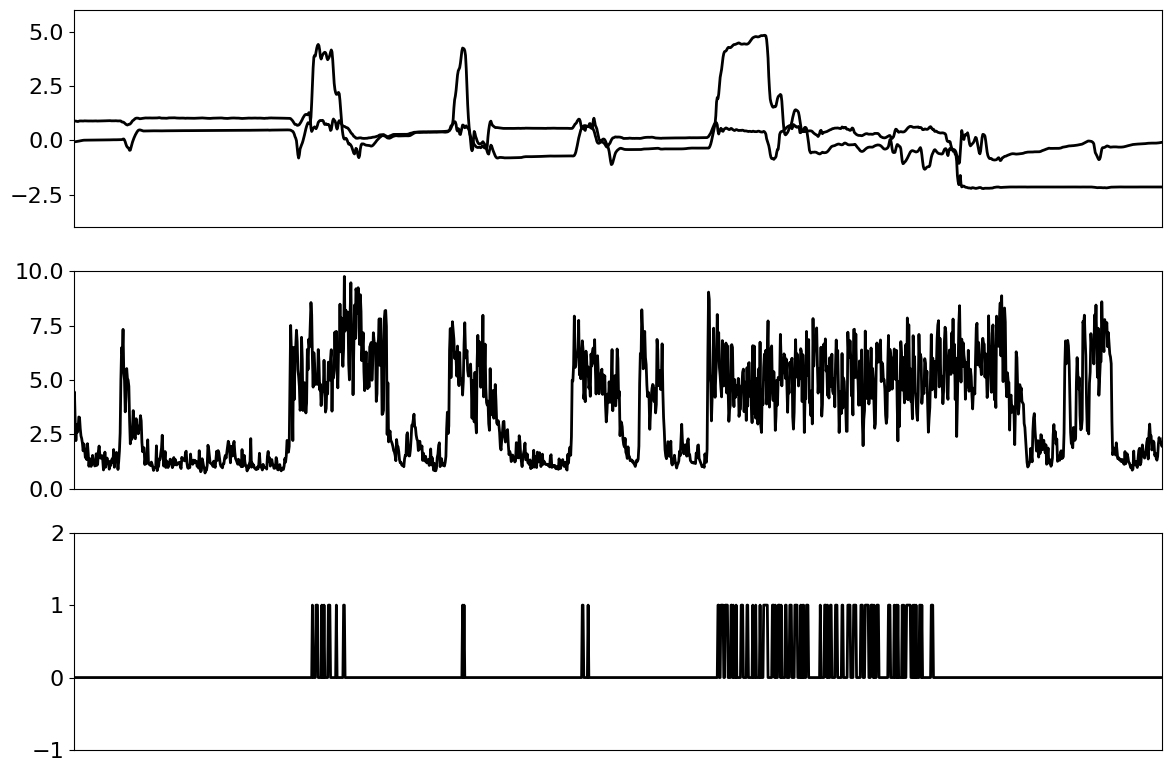

In [41]:
init = 1500
inter = 1500
plot_raw_trace(init, inter, use_data, ['l_paw_x', 'r_paw_x', 'whisker_me', 'Lick count'])

In [ ]:
def wheel_over_wavelet_clusters(init, inter, empirical_data):
    # Plot raw trace over states
    # init should be in seconds; inter should be in frames
    frame_rate = 60
    plot_min = -5
    plot_max=5
    fig, ax = plt.subplots(ncols=1 , nrows=1, sharex=False, sharey=False, figsize=[12, 4])
    plt.rc('font', size=16)

    colormap = create_grouped_gradient_palette(n_groups=4, shades_per_group=4, base_palette='tab10')
    cax = ax.imshow(np.concatenate([empirical_data.loc[empirical_data['Bin']>=init, 'most_likely_states']])[None,:],
                extent=(0, len(np.concatenate([empirical_data.loc[empirical_data['Bin']>=init, 'most_likely_states']])), plot_min, plot_max),
                aspect="auto",
                cmap=colormap,
                alpha=0.5)
    cbar = fig.colorbar(cax, ax=ax)
    cbar.set_label('Syllable')
    cbar.ax.invert_yaxis()
    if len(inverted_mapping) > 0:
        # Set the ticks and labels based on the dictionary
        cbar.set_ticks(list(inverted_mapping.keys()))
        cbar.set_ticklabels(list(inverted_mapping.values()))

    ax.set_xlim([init, init+inter])
    ax.set_ylabel('')
    ax.set_xlabel("Time (s)")
    ax.set_xticks(np.arange(init, init+inter, inter/5), np.round(np.arange(init/frame_rate, 
                  (init+inter)/frame_rate, (inter/frame_rate)/5), 1))
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
    ax.set_ylim([plot_min, plot_max])

    plt.tight_layout()    
    plt.savefig(save_path+'conjunction_states_raw.svg', format="svg")

    plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


NameError: name 'save_path' is not defined

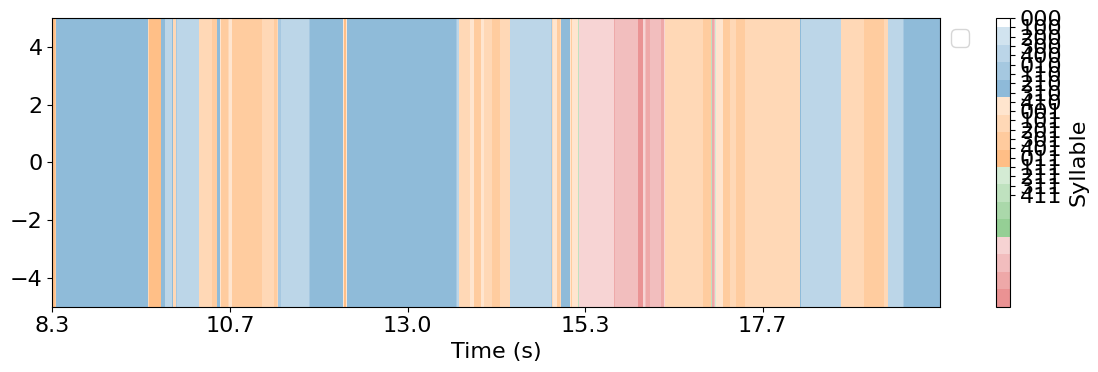

In [ ]:
init = 500
inter = 700
wheel_over_wavelet_clusters(init, inter, use_data)

# Histogram

/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/seaborn/_oldc

Text(0.5, 0, 'Time from stimulus onset (s)')

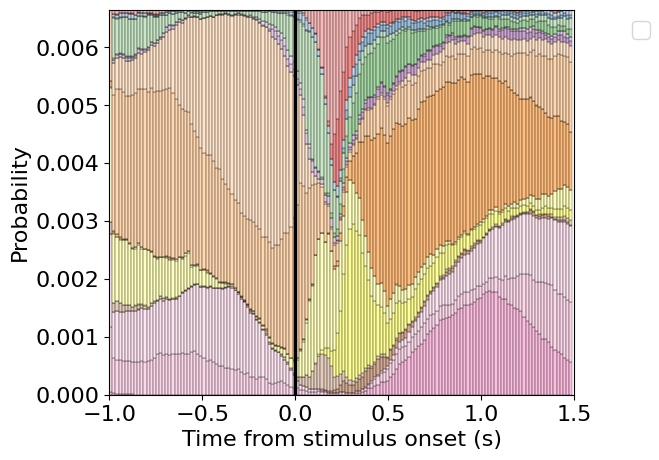

In [ ]:
bin_size=.0167
palette_16 = create_grouped_gradient_palette(n_groups=8, shades_per_group=4, base_palette='Set1')
palette_16_list = [palette_16(i) for i in range(palette_16.N)]  # Extract colors properly
order = ['000', '100', '200', '300', '010', '110',
           '210', '310', '001', '101', '201', '301', '011',
           '111', '211', '311']
order = ['000', '010', '001', '011', '100', '110', '101', '111', '200', '210', '201', '211',
         '300', '310', '301', '311', '400', '410',  '401', '411',
         '500', '510', '501', '511', '600', '610', '601', '611',
         '700', '710', '701', '711']
state_to_color = dict(zip(order, palette_16_list))
plt.figure(figsize=[6, 5])
plt.rc('font', size=16)

sns.histplot(x='new_bin', hue='identifiable_states', data=use_data, stat='probability', alpha=0.5, 
                    multiple="stack", legend=True,palette=state_to_color, hue_order=order, binwidth=bin_size)
plt.vlines(0, 0, 1, color='Black', linewidth=2.5)
plt.legend(loc='upper left', bbox_to_anchor=(1.1, 1))
plt.ylim(0, 0.00665)
# plt.ylim(0, 0.010665)
plt.xlim(-1.5, 2)
plt.xlabel('Time from stimulus onset (s)')
# plt.savefig(save_path+'trial_stack_histogram.svg', format="svg")